# Raster to H3

In [1]:
import os

from h3ronpy import raster
import rasterio
import matplotlib.pyplot as plt
from pandas import DataFrame

In [2]:
file_path = "test_data/geotif/sample.tif"
#file_path = "test_data/geotif/sample-2.tif"

In [3]:
resolution = 4

In [4]:
print("Running input checks...")

# Check if the file exists
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

Running input checks...


In [5]:
# Open the dataset
print(f"Opening dataset: {file_path}")
dataset = rasterio.open(file_path)

Opening dataset: test_data/geotif/sample.tif


In [6]:
# Get the specs of the dataset
dataset_height = dataset.height
dataset_width = dataset.width
print(f"Width: {dataset_width}")
print(f"Height: {dataset_height}")
print(f"Bounds: {dataset.bounds}")

# Band data types
print({i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)})

Width: 1001
Height: 1001
Bounds: BoundingBox(left=590520.0, bottom=5780620.0, right=600530.0, top=5790630.0)
{1: 'uint16', 2: 'uint16', 3: 'uint16'}


In [7]:
print(f"Number of bands: {dataset.count}")
if dataset.count > 1:
    print("The dataset has more than one band. Only the first band will be used.")

Number of bands: 3
The dataset has more than one band. Only the first band will be used.


In [8]:
# Create Numpy ndarray from tiff
print("Creating numpy.ndarray raster...")
# Which band to read
band = 1

# Only read part of the raster e.g. for testing large files
use_window = True
window = [0, 0, 1000, 1000]
if use_window:
    if window[0] + window[2] > dataset_width or window[1] + window[3] > dataset_height:
        raise ValueError(f"Window {window} is out of bounds of the dataset. Decrease the window size or change window coordinates.")
    ndarray_raster = dataset.read(band, window=rasterio.windows.Window(window[0], window[1], window[2], window[3]))
else:
    ndarray_raster = dataset.read(band)

print(ndarray_raster)
print(type(ndarray_raster))
print(ndarray_raster.shape)

Creating numpy.ndarray raster...
[[   0  799  788 ... 1059 1061 1433]
 [   0  774  792 ... 1043 1027 1125]
 [   0  797  801 ... 1038 1046 1040]
 ...
 [   0  829  818 ... 1438 1383 1543]
 [   0  826  837 ... 1671 1562 1489]
 [   0  804  825 ... 1416 1553 1582]]
<class 'numpy.ndarray'>
(1000, 1000)


In [9]:
# Get optimal H3 resolution for raster
optimal_h3_res = raster.nearest_h3_resolution(
    shape=ndarray_raster.shape,
    transform=dataset.transform,
    search_mode="smaller_than_pixel"
)
print(f"Optimal H3 resolution: {optimal_h3_res}")

# Check if the requested resolution is smaller than or equal to the optimal resolution
if optimal_h3_res > resolution:
    print(
        f"Optimal H3 resolution is {optimal_h3_res}, but the requested resolution is {resolution}. This will result in a loss of information.")
elif optimal_h3_res < resolution:
    raise ValueError(
        f"Optimal H3 resolution is {optimal_h3_res}, but the requested resolution is {resolution}. Cannot create H3 indexes with a higher resolution than the raster resolution.")

Optimal H3 resolution: 4


Plotting raster...


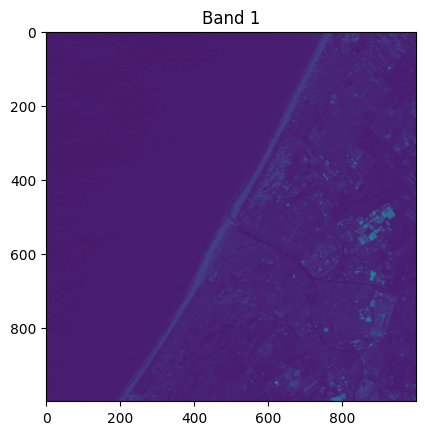

In [10]:
# Plot the raster
print("Plotting raster...")
plt.title(f"Band {band}")
plt.imshow(ndarray_raster)

In [11]:
import earthpy
# Check input geometry
dataset_crs = dataset.crs
print(f"dataset.crs: {dataset_crs}")
proj4 = earthpy.epsg[str(dataset_crs.to_epsg())]
projection_metadata = dict(x.split("=") for x in proj4.replace("+","").split(" ") if "=" in x)
projection_metadata

dataset.crs: EPSG:32631


{'proj': 'utm', 'zone': '31', 'datum': 'WGS84', 'units': 'm'}

In [12]:
implemented_projections = ["WGS84"]

if projection_metadata["datum"] not in implemented_projections:
    raise ValueError(f"The conversion service is only implemented for input geometry of type WGS84, but the input geometry is {projection_metadata['datum']}.")

In [13]:
# Convert a raster/array to a pandas dataframe containing H3 indexes
print("Converting raster to a pandas dataframe containing H3 indexes...")
h3_dataframe = raster.raster_to_dataframe(ndarray_raster, dataset.transform, resolution, compacted=False, geo=False)
print("Converted tiff to H3 dataframe")

Converting raster to a pandas dataframe containing H3 indexes...


RuntimeError: operation failed

In [129]:
h3_dataframe.head()

,h3index,value
0,600853788206563327,0
1,600853789280305151,0
2,600853791427788799,0
